# Exploratory Data Analysis and Data Preparation

This notebook explores the **HDF5-based** dataset (as described in the PDF) and prepares it for Vision Transformer (ViT) based segmentation.

## Contents
1. Setup and Imports
2. Data Loading and Inspection (HDF5)
3. Exploratory Data Analysis
4. Data Preprocessing (HDF5 -> Torch Dataset)
5. Data Preparation for ViT

In [9]:
%pip install --quiet imageio

Note: you may need to restart the kernel to use updated packages.


In [20]:
import imageio
import random
import time

import h5py
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from matplotlib.colors import ListedColormap
from src.config import get_dataset_path
from torch.utils.data import DataLoader, Dataset

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_context('notebook')

## 1. Setup and Configuration

We will open the HDF5 file using a config-based path retrieval (`get_dataset_path`). The PDF describes that images and masks reside within different internal groups, such as:

- `slices/camera_data/visible/0` (images captured after each layer is melted)
- `slices/camera_data/visible/1` (images captured after new powder is spread)
- `slices/segmentation_results/0..11` (binary masks for each anomaly class, per layer)

We can select which slice or segmentation data we want to examine (e.g. `0` for Powder, `1` for Printed, etc.).

In [2]:
path_file = get_dataset_path("tcr_phase1_build2")
if path_file is None:
    raise FileNotFoundError(
        "Dataset not found. Please check the configuration and data directory."
    )

print("Using HDF5 file:", path_file)

Using HDF5 file: /mnt/ssd/l-pbf-dataset/2021-04-16 TCR Phase 1 Build 2.hdf5


## 2. Data Loading and Inspection (HDF5)

We’ll open the HDF5 file and look at:
- Top-level metadata
- The shape and content of the slice images (`slices/camera_data/visible/0`)
- The shape and content of segmentation results (`slices/segmentation_results/0`, `1`, etc.)

In [3]:
with h5py.File(path_file, "r") as f:
    print("\nTop-level Attributes (Build Metadata):")
    for k, v in f.attrs.items():
        print(f"  {k} : {v}")

    # Example check: shapes of certain datasets
    slice_dset_name = "slices/camera_data/visible/0"  # post-melt images
    seg_dset_name   = "slices/segmentation_results/8" # spatter

    print("\nChecking if these datasets exist in the HDF5...")
    if slice_dset_name in f:
        ds_slice = f[slice_dset_name]
        print(f"{slice_dset_name} shape = {ds_slice.shape}")
    else:
        print(f"Dataset {slice_dset_name} NOT FOUND.")

    if seg_dset_name in f:
        ds_seg = f[seg_dset_name]
        print(f"{seg_dset_name} shape = {ds_seg.shape}")
    else:
        print(f"Dataset {seg_dset_name} NOT FOUND.")


Top-level Attributes (Build Metadata):
  core/build_name : TCR Phase 1 Build 2
  core/change_log : 
2021/04/21 09:05:32 v20.7.4: RABBAKAS [l03] instantiated the change log 
2021/04/21 09:05:32 v20.7.4: RABBAKAS [l03] created a new analysis file 
<> 2021/04/21 09:05:32: build name: TCR Phase 1 Build 2
<> 2021/04/21 09:05:32: build start date: 2021-04-16
<> 2021/04/21 09:05:32: using workspace: ConceptLaser M2 v3
<> 2021/04/21 09:05:32: using calibration file: ORNL1+20210414
<> 2021/04/21 09:05:32: using live configuration file: none
<> 2021/04/21 09:05:32: using stitching configuration file: none
<> 2021/04/21 09:05:32: dataset sensitivity marked as: False
<> 2021/04/21 09:05:32: loaded the workspace file created on: 2021-04-15_14-14-04
<> 2021/04/21 09:05:32: loaded the ORNL1+20210414 calibration file created on: 2021-04-14_17-21-42
<> 2021/04/21 09:05:33: loaded the DSCNN model created on: 2021-04-07_16-49-32
<> 2021/04/21 09:05:33: loaded the DSCNN-P model created on: 2021-04-08_11-

### Listing HDF5 Structure
If you want to see the entire group/dataset hierarchy, uncomment below to walk the file’s structure.

In [4]:
# with h5py.File(path_file, "r") as f:
#     def print_structure(name, obj):
#         print(name)
#     print("\n--- HDF5 Structure ---")
#     f.visititems(print_structure)

## 3. Exploratory Data Analysis

We’ll pick a few random layers from `slices/camera_data/visible/0` and compute basic stats.
Note that `ds_slice[layer]` is a 2D array (height, width).

In [5]:
def get_slice_stats(h5_file, dset_name, num_samples=5):
    """Compute mean/std/min/max for a few random layers."""
    if dset_name not in h5_file:
        print(f"Dataset '{dset_name}' not found!")
        return
    ds = h5_file[dset_name]
    num_layers = ds.shape[0]
    layer_indices = random.sample(range(num_layers), min(num_layers, num_samples))

    for layer_idx in layer_indices:
        arr = ds[layer_idx, ...]
        mean_val = arr.mean()
        std_val = arr.std()
        min_val = arr.min()
        max_val = arr.max()
        print(f"Layer {layer_idx}: mean={mean_val:.3f}, std={std_val:.3f}, min={min_val}, max={max_val}")  # noqa: E501

with h5py.File(path_file, "r") as f:
    print("\nSample stats from 'slices/camera_data/visible/0':")
    get_slice_stats(f, "slices/camera_data/visible/0", num_samples=3)


Sample stats from 'slices/camera_data/visible/0':


Layer 338: mean=101.625, std=32.467, min=11.0, max=255.0
Layer 331: mean=104.132, std=33.525, min=11.0, max=255.0
Layer 331: mean=104.132, std=33.525, min=11.0, max=255.0
Layer 2969: mean=102.853, std=7.928, min=15.0, max=255.0
Layer 2969: mean=102.853, std=7.928, min=15.0, max=255.0


We can also **visualize** a single layer’s slice image to see how it looks.

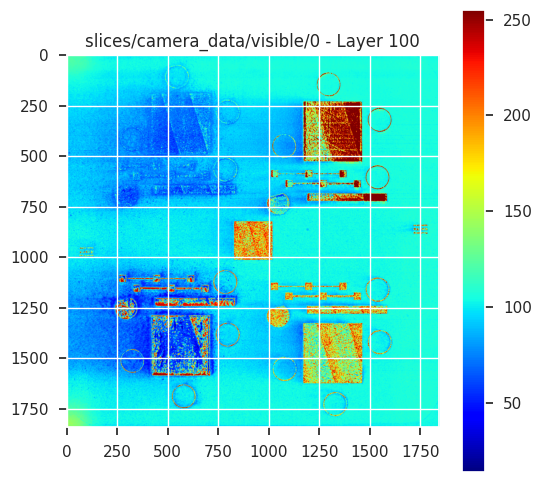

In [6]:
def plot_layer_image(h5_file, dset_name, layer_idx=600, cmap='gray'):
    if dset_name not in h5_file:
        print(f"Dataset '{dset_name}' not found!")
        return
    ds = h5_file[dset_name]
    if layer_idx < 0 or layer_idx >= ds.shape[0]:
        print(f"layer_idx {layer_idx} out of range!")
        return

    img_2d = ds[layer_idx, ...]
    plt.figure(figsize=(6,6))
    plt.imshow(img_2d, cmap=cmap)
    plt.title(f"{dset_name} - Layer {layer_idx}")
    plt.colorbar()
    plt.show()

with h5py.File(path_file, "r") as f:
    plot_layer_image(f, "slices/camera_data/visible/0", layer_idx=100, cmap='jet')

(np.float64(-0.5), np.float64(1841.5), np.float64(1841.5), np.float64(-0.5))

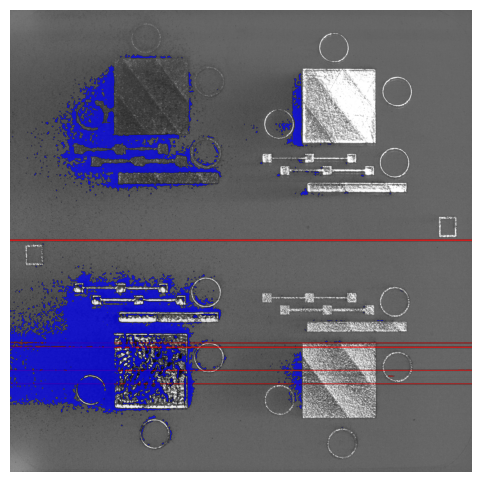

In [7]:
cmap_streak = ListedColormap([(0, 0, 0, 0), 
                              (1, 0, 0, 0.7)]) 


cmap_spatter = ListedColormap([(0, 0, 0, 0), 
                               (0, 0, 1, 0.7)])

layer = 600
with h5py.File(path_file, "r") as f:
    img  = f["slices/camera_data/visible/0"][layer]
    m3   = f["slices/segmentation_results/3"][layer]  # streak
    m8   = f["slices/segmentation_results/8"][layer]  # spatter

plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
plt.imshow(m3, cmap=cmap_streak)
plt.imshow(m8, cmap=cmap_spatter)
plt.axis("off")

YOLO data visualizatiion

/tmp/ipykernel_1348/3784260618.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img  = imageio.imread("../data/legacy/tcr_phase1_build2/images/train/00060.png")
/tmp/ipykernel_1348/3784260618.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread("../data/legacy/tcr_phase1_build2/labels/train/00060.png")


(np.float64(-0.5), np.float64(1841.5), np.float64(1841.5), np.float64(-0.5))

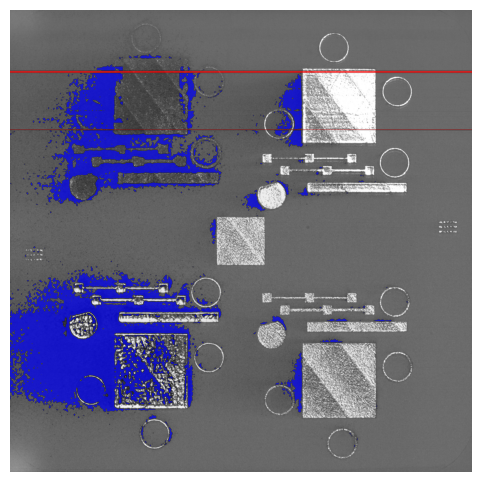

In [11]:
# load
img  = imageio.imread("../data/legacy/tcr_phase1_build2/images/train/00060.png")
mask = imageio.imread("../data/legacy/tcr_phase1_build2/labels/train/00060.png")

# define semi-transparent colormaps
cmap_spatter = ListedColormap([(0,0,0,0), (0,0,1,0.7)])  # blue
cmap_streak  = ListedColormap([(0,0,0,0), (1,0,0,0.7)])  # red

# build boolean masks
m_sp = mask==1
m_st = mask==2

plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
plt.imshow(m_sp, cmap=cmap_spatter)
plt.imshow(m_st, cmap=cmap_streak)
plt.axis("off")

Counting the number of pixels for an anomaly, to test how fast it could be determined.

In [25]:
with h5py.File(path_file, "r") as f:
    layer_idx = 200
    spatter_mask = f["slices/segmentation_results/8"][layer_idx]
    start = time.perf_counter()
    spatter_pixel_count = np.count_nonzero(spatter_mask)
    elapsed = time.perf_counter() - start
    print(
        f"Number of spatter anomaly pixels in layer {layer_idx}: "
        f"{spatter_pixel_count}"
    )
    print(f"Time taken: {elapsed*1e3:.3f} ms")

Number of spatter anomaly pixels in layer 200: 444934
Time taken: 1.359 ms


## 4. Data Preprocessing (HDF5 -> Torch Dataset)

Instead of reading PNG files, we define a custom PyTorch `Dataset` that reads directly from the HDF5 file. For each index (which corresponds to a layer), we retrieve:
- An image from `camera_data/visible/0` (for instance)
- A segmentation mask from `slices/segmentation_results/1` (if desired)

Because we have **one HDF5 file** containing many layers, we can open it once in the dataset’s constructor, or pass a path and open lazily. The example below keeps it open, so we must ensure it is closed properly. Alternatively, you can open it in `__getitem__` each time, but that’s slower.

> **Note**: If you want multiple segmentation classes, you might read multiple `slices/segmentation_results/#` arrays, or combine them. Below we just load a single mask dataset for demonstration.

In [12]:
class HDF5MetalDataset(Dataset):
    """Custom dataset reading from HDF5 for images and masks."""

    def __init__(
        self,
        hdf5_path,
        image_dset="slices/camera_data/visible/0",
        mask_dset=None,
        transform=None
    ):
        super().__init__()
        self.hdf5_path = hdf5_path
        self.image_dset_name = image_dset
        self.mask_dset_name = mask_dset
        self.transform = transform

        self.h5_file = h5py.File(
            hdf5_path, 'r'
        )

        if self.image_dset_name not in self.h5_file:
            raise ValueError(f"Image dataset '{self.image_dset_name}' not found in HDF5.")  # noqa: E501
        self.img_ds = self.h5_file[self.image_dset_name]
        self.num_layers = self.img_ds.shape[0]

        if self.mask_dset_name:
            if self.mask_dset_name not in self.h5_file:
                raise ValueError(f"Mask dataset '{self.mask_dset_name}' not found in HDF5.")  # noqa: E501
            self.mask_ds = self.h5_file[self.mask_dset_name]
            if self.mask_ds.shape[0] != self.num_layers:
                raise ValueError("Image and mask dataset layer counts do not match!")
        else:
            self.mask_ds = None

    def __len__(self):
        return self.num_layers

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.num_layers:
            raise IndexError("Layer index out of range.")

        img_2d = self.img_ds[idx, ...].astype(np.float32)
        img_3ch = np.stack([img_2d, img_2d, img_2d], axis=0)  # shape (3, H, W)

        mask_2d = None
        if self.mask_ds is not None:
            mask_2d = self.mask_ds[idx, ...].astype(np.uint8)

        if self.transform:
            # Convert to a Range [0,1], etc., or do standard transforms
            # We'll do the final transform outside of __getitem__ for clarity.
            pass

        img_tensor = torch.from_numpy(img_3ch)  # shape: (3, H, W)
        mask_tensor = None
        if mask_2d is not None:
            mask_tensor = torch.from_numpy(mask_2d)  # shape: (H, W)

        return {
            'image': img_tensor,
            'mask': mask_tensor,
            'layer_index': idx
        }

    def close(self):
        """Close the HDF5 file when done."""
        self.h5_file.close()


## 5. Data Preparation for YOLO

This process takes about 3 hours. 

In [13]:
# !python ../src/utils/export_to_yolo_data.py \
#         tcr_phase1_build2 \
#         --val_split 0.15 \
#         --workers 6

## 6. Data Preparation for ViT

Let’s create an instance of our `HDF5MetalDataset`, specifying one dataset for images and one for masks. Then we can define standard transforms for the Vision Transformer (e.g. resizing to 224×224). We’ll use `torchvision.transforms` on the Tensor.

Finally, we create a DataLoader for training. When done, remember to call `.close()` on the dataset (or handle it via a context manager) so the HDF5 file is closed properly.

In [14]:
image_dset_path = "slices/camera_data/visible/0"
mask_dset_path  = "slices/segmentation_results/8" # spatter

In [15]:
class ViTResizeTransform:
    def __init__(self, size=224):
        self.size = size
    def __call__(self, sample):
        img = sample['image'].float()  # shape: (3, H, W)
        import torchvision.transforms.functional as F
        img_pil = F.to_pil_image(img)
        img_resized = F.resize(img_pil, (self.size, self.size))
        img_t = F.to_tensor(img_resized)
        img_t = F.normalize(img_t, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # noqa: E501

        sample['image'] = img_t

        if sample['mask'] is not None:
            mask = sample['mask']
            # Convert (H,W) -> PIL -> resize
            mask_pil = F.to_pil_image(mask.unsqueeze(0))  # expand dims to (1,H,W)
            mask_resized = F.resize(
                mask_pil, 
                (self.size, self.size), 
                interpolation=F.InterpolationMode.NEAREST
            )
            mask_t = torch.as_tensor(np.array(mask_resized), dtype=torch.long)
            sample['mask'] = mask_t

        return sample

dataset = HDF5MetalDataset(
    hdf5_path=path_file,
    image_dset=image_dset_path,
    mask_dset=mask_dset_path
)

print("Number of layers in dataset =", len(dataset))

# We'll define a small wrapper dataset that applies transforms to each item.
class TransformWrapper(Dataset):
    def __init__(self, base_dataset, transform):
        self.base = base_dataset
        self.transform = transform
    def __len__(self):
        return len(self.base)
    def __getitem__(self, idx):
        sample = self.base[idx]
        sample = self.transform(sample)
        return sample

vit_transform = ViTResizeTransform(size=224)
wrapped_dataset = TransformWrapper(dataset, vit_transform)

# Now create a DataLoader
dataloader = DataLoader(
    wrapped_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0  # set to >0 if it suits your environment
)

# Let's check a single batch
batch = next(iter(dataloader))
print("Batch keys:", batch.keys() if isinstance(batch, dict) else batch[0].keys())
print("Images shape:", batch['image'].shape)
if batch['mask'] is not None:
    print("Masks shape:", batch['mask'].shape)
print("Layer indices:", batch['layer_index'])

# Make sure to close the underlying HDF5 file when done:
dataset.close()

Number of layers in dataset = 3561


Batch keys: dict_keys(['image', 'mask', 'layer_index'])
Images shape: torch.Size([4, 3, 224, 224])
Masks shape: torch.Size([4, 224, 224])
Layer indices: tensor([ 490, 2310, 2098,  880])


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Class names and colors for each defect
class_names = [
    "Powder", "Printed", "Recoater Hopping", "Recoater Streaking",
    "Incomplete Spreading", "Swelling", "Debris", "Super-Elevation",
    "Spatter", "Misprint", "Over Melting", "Under Melting"
]
class_colors = [
    (0.7, 0.7, 0.7, 0.5),  # Powder: gray
    (0.2, 0.2, 0.2, 0.5),  # Printed: dark gray
    (1, 0.5, 0, 0.5),      # Recoater Hopping: orange
    (1, 0, 0, 0.5),        # Recoater Streaking: red
    (1, 1, 0, 0.5),        # Incomplete Spreading: yellow
    (0.5, 0, 1, 0.5),      # Swelling: purple
    (0, 1, 0, 0.5),        # Debris: green
    (0, 1, 1, 0.5),        # Super-Elevation: cyan
    (0, 0, 1, 0.5),        # Spatter: blue
    (1, 0, 1, 0.5),        # Misprint: magenta
    (0.5, 0.3, 0, 0.5),    # Over Melting: brown
    (0, 0, 0, 0.5),        # Under Melting: black
]

layer_idx = 100  # Example layer to visualize

with h5py.File(path_file, "r") as f:
    img = f["slices/camera_data/visible/0"][layer_idx]
    plt.figure(figsize=(18, 12))
    plt.subplot(3, 5, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Visible Image (Layer {} )".format(layer_idx))
    plt.axis("off")
    for i in range(12):
        mask = f[f"slices/segmentation_results/{i}"][layer_idx]
        cmap = ListedColormap([(0, 0, 0, 0), class_colors[i]])
        plt.subplot(3, 5, i+2)
        plt.imshow(img, cmap="gray")
        plt.imshow(mask, cmap=cmap)
        plt.title(f"{i}: {class_names[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()